# Image Model


In [1]:
import torch
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import hdbscan
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
import json
from umap import UMAP
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image as kimage
import io
import pandas as pd
import matplotlib.ticker as ticker
import embedding_data

### **Important**: If you want to use the precomputed local embeddings data (located at /embeddings), please set the variable "use_embeddings_data" to True. This will save time by skipping the recalculation of embeddings.

"use_embeddings_data" equals True will need 4 files:

- hybrid_embeddings located at /embeddings
- json_data_fact_checking located at /image_model
- json_data_fast_check_1_fixed located at /image_model
- json_data_fast_check_2_fixed located at /image_model


In [3]:
use_embeddings_data = True

In [17]:
if not use_embeddings_data: 
    model = EfficientNetB0(weights="imagenet", include_top=False, pooling="avg") 

In [18]:
def download_image(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    return image

def check_images(data):
    pages_checked = data
    pages_urls = []
    images_downloaded = []
    relationships = []
    index = 0

    for page in data:
        images = []
        try: 
            for image in page["images"]:
                try:
                    download = download_image(image["image"]) 
                    images_downloaded.append(download)
                    images.append(image)
                except:
                    print(f"[{image['image']}]No fue posible descargar la imagen. Arreglando")
                    continue
            pages_checked[index]["images"] = images
            relationships.append(len(images))
            index += 1
            pages_urls += images
        except Exception as e:
            print("error al analizar la pagina")
            print(e)
            continue 
        
    print(f"Imagenes analizadas: {len(pages_urls)}")
    pages_checked = {"pages": pages_checked, "downloaded_images": images_downloaded, "relationships": relationships}
    
    return pages_checked

In [19]:
if not use_embeddings_data: 
    json_data = {}
    with open("../../data/json_data_fast_check_1_fixed.json", 'r', encoding='utf-8') as file:
        json_data = json.load(file)
    json_data_fast_check_1_fixed = check_images(json_data["pages"])

Imagenes analizadas: 76


In [20]:
if not use_embeddings_data: 
    json_data = {}
    with open("../../data/json_data_fast_check_2_fixed.json", 'r', encoding='utf-8') as file:
        json_data = json.load(file)
    json_data_fast_check_2_fixed = check_images(json_data["pages"])

Imagenes analizadas: 33


In [21]:
if not use_embeddings_data: 
    json_data = {}
    with open("../../data/json_data_fact_checking_fixed.json", 'r', encoding='utf-8') as file:
        json_data = json.load(file)
    json_data_fact_checking_fixed = check_images(json_data["pages"])

Imagenes analizadas: 114


In [22]:
if not use_embeddings_data: 
    json_data = {}
    with open("../../data/json_data_biobiochile_fixed.json", 'r', encoding='utf-8') as file:
        json_data = json.load(file)
    json_data_biobiochile_fixed = check_images(json_data["pages"])

Imagenes analizadas: 77


In [23]:
def get_image_embeddings(images):
    with torch.no_grad():
    # inputs = processor(images=json_data_fast_check_1_fixed["downloaded_images"], return_tensors="pt")
    # outputs = model.get_image_features(**inputs)
    # image_embeddings = outputs
    # torch.save(image_embeddings, '1st_image_embeddings.pt')
        processed_images = []
        for index, pil_image in enumerate(images["downloaded_images"]):
            image_bytes = io.BytesIO()
            pil_image.save(image_bytes, format="JPEG")
            image_bytes.seek(0)
            img = kimage.load_img(image_bytes, target_size=(224, 224))
            img_array = kimage.img_to_array(img)
            img_array = preprocess_input(img_array)
            processed_images.append(img_array)
        batch = np.array(processed_images)
        image_embeddings = model.predict(batch)
        return image_embeddings
        # torch.save(image_embeddings, '1st_image_embeddings.pt')

In [24]:
if not use_embeddings_data: 
    image_embeddings_fast_check_1_fixed = get_image_embeddings(json_data_fast_check_1_fixed)
    image_embeddings_fast_check_2_fixed = get_image_embeddings(json_data_fast_check_2_fixed)
    image_embeddings_biobiochile_fixed = get_image_embeddings(json_data_biobiochile_fixed)
    image_embeddings_fact_checking_fixed = get_image_embeddings(json_data_fact_checking_fixed)

    torch.save(image_embeddings_fast_check_1_fixed, '1st_image_embeddings.pt')
    torch.save(image_embeddings_fast_check_2_fixed, '2nd_image_embeddings.pt')
    torch.save(image_embeddings_biobiochile_fixed, 'biobiochile_image_embeddings.pt')
    torch.save(image_embeddings_fact_checking_fixed, 'fact_checking_image_embeddings.pt')

3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


In [13]:
if not use_embeddings_data: 
    json_data_fact_checking = {"pages": json_data_fact_checking_fixed["pages"]}
    json_data_fast_check_1 = {"pages": json_data_fast_check_1_fixed["pages"]}
    json_data_fast_check_2 = {"pages": json_data_fast_check_2_fixed["pages"]}
    json_data_biobiochile = {"pages": json_data_biobiochile_fixed["pages"]}
    row_data = {"pages": []}
    row_data = json_data_fact_checking_fixed["pages"] + json_data_fast_check_1_fixed["pages"] + json_data_fast_check_2_fixed["pages"] + json_data_biobiochile_fixed["pages"]

    with open(f"../../data/json_data_fact_checking_fixed.json", 'w', encoding='utf-8') as file:
        json.dump(json_data_fact_checking, file, ensure_ascii=False, indent=4)
    with open(f"../../data/json_data_fast_check_1_fixed.json", 'w', encoding='utf-8') as file:
        json.dump(json_data_fast_check_1, file, ensure_ascii=False, indent=4)
    with open(f"../../data/json_data_fast_check_2_fixed.json", 'w', encoding='utf-8') as file:
        json.dump(json_data_fast_check_2, file, ensure_ascii=False, indent=4)
    with open(f"../../data/json_data_biobiochile_fixed.json", 'w', encoding='utf-8') as file:
        json.dump(json_data_biobiochile, file, ensure_ascii=False, indent=4)

else: 
    json_data_fact_checking = {}
    json_data_fast_check_1 = {}
    json_data_fast_check_2 = {}
    json_data_biobiochile = {}
    row_data = {"pages": []}

    with open(f"../../data/json_data_fact_checking_fixed.json", 'r', encoding='utf-8') as file:
        json_data_fact_checking = json.load(file)
        row_data["pages"] = json_data_fact_checking["pages"]
    with open(f"../../data/json_data_fast_check_1_fixed.json", 'r', encoding='utf-8') as file:
        json_data_fast_check_1 = json.load(file)
        row_data["pages"] += json_data_fast_check_1["pages"]
    with open(f"../../data/json_data_fast_check_2_fixed.json", 'r', encoding='utf-8') as file:
        json_data_fast_check_2 = json.load(file)
        row_data["pages"] += json_data_fast_check_2["pages"]
    with open(f"../../data/json_data_biobiochile_fixed.json", 'r', encoding='utf-8') as file:
        json_data_biobiochile = json.load(file)
        row_data["pages"] += json_data_biobiochile["pages"]

In [5]:
#Estructura de datos para guardar las relaciones entre las imagenes y las noticias
relationships = []
image_relationships = []

all_pages = json_data_fast_check_1["pages"] + json_data_fast_check_2["pages"] + json_data_fact_checking["pages"] + json_data_biobiochile["pages"]
    
for page in all_pages:
    relationships.append(len(page["images"]))
    for image in page["images"]:
        image_relationships.append({"image": image, "page": page})

#Crea una lista de cluster para luego visualizar que imagen pertenece a que noticia.
amount = 0
cluster_relationships = []
for index, relation in enumerate(relationships):
    amount += relation
    if relation == 0:
        continue
    for i in range(relation):
        cluster_relationships.append(index)

In [6]:
count_images = 0

for page in all_pages:
    count_images += len(page["images"])

print(f"Total de imagenes: {count_images}")

print(len(cluster_relationships))

Total de imagenes: 300
300


In [7]:
image_embeddings_1st = torch.load('1st_image_embeddings.pt')
image_embeddings_2nd = torch.load('2nd_image_embeddings.pt')
image_embeddings_fact_checking = torch.load('fact_checking_image_embeddings.pt')
image_embeddings_biobiochile = torch.load('biobiochile_image_embeddings.pt')
text_embeddings_1st = torch.load('../text_model/1st_RoBERTa_text_embeddings.pt')
text_embeddings_2nd = torch.load('../text_model/2nd_RoBERTa_text_embeddings.pt')
text_embeddings_fact_checking = torch.load('../text_model/fact_checking_RoBERTa_text_embeddings.pt')
text_embeddings_biobiochile = torch.load('../text_model/biobiochile_RoBERTa_text_embeddings.pt')

#Text
if not isinstance(text_embeddings_biobiochile, torch.Tensor):
    text_embeddings_biobiochile = torch.tensor(text_embeddings_biobiochile.tolist())
if not isinstance(text_embeddings_fact_checking, torch.Tensor):
    text_embeddings_fact_checking = torch.tensor(text_embeddings_fact_checking.tolist())
if not isinstance(text_embeddings_1st, torch.Tensor):
    text_embeddings_1st = torch.tensor(text_embeddings_1st.tolist())
if not isinstance(text_embeddings_2nd, torch.Tensor):
    text_embeddings_2nd = torch.tensor(text_embeddings_2nd.tolist())

hybrid_text_embeddings = torch.cat((text_embeddings_1st, text_embeddings_2nd, text_embeddings_fact_checking, text_embeddings_biobiochile), dim=0)
hybrid_text_embeddings = torch.cat(
    [hybrid_text_embeddings[i].unsqueeze(0).repeat(n, 1) for i, n in enumerate(relationships) if n != 0],
    dim=0
)

#Images
if not isinstance(image_embeddings_1st, torch.Tensor):
    image_embeddings_1st = torch.tensor(image_embeddings_1st.tolist())
if not isinstance(image_embeddings_2nd, torch.Tensor):
    image_embeddings_2nd = torch.tensor(image_embeddings_2nd.tolist())
if not isinstance(image_embeddings_fact_checking, torch.Tensor):
    image_embeddings_fact_checking = torch.tensor(image_embeddings_fact_checking.tolist())
if not isinstance(image_embeddings_biobiochile, torch.Tensor):
    image_embeddings_biobiochile = torch.tensor(image_embeddings_biobiochile.tolist())

hybrid_image_embeddings = torch.cat((image_embeddings_1st, image_embeddings_2nd, image_embeddings_fact_checking, image_embeddings_biobiochile), dim=0)

#Concatenación
print(f"text shape: {hybrid_text_embeddings.shape}")
print(f"image shape: {hybrid_image_embeddings.shape}")
hybrid_embeddings = torch.cat((hybrid_text_embeddings, hybrid_image_embeddings), dim=1)

#Forma Final
print(hybrid_embeddings.shape)
torch.save(hybrid_embeddings, 'hybrid_embeddings.pt')
hybrid_embeddings = torch.load('hybrid_embeddings.pt')

C:\Users\usuario\AppData\Local\Temp\ipykernel_9544\4211518510.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_embeddings_1st = torch.load('1st_image_embeddings.pt'

text shape: torch.Size([300, 1024])
image shape: torch.Size([300, 1280])
torch.Size([300, 2304])


C:\Users\usuario\AppData\Local\Temp\ipykernel_9544\4211518510.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hybrid_embeddings = torch.load('hybrid_embeddings.pt')


# **Important**

# If you want to use the precomputed local embeddings data (located at /embeddings), please set the variable "use_embeddings_data" to **True** at the start of this code. This will save time by avoiding the recalculation of embeddings.

# If you want to recalculate the embeddings, set the variable "use_embedding_data" to **False** at the start of this code.


In [30]:
umap_model= UMAP(n_components=70, random_state=40)
embeddings_2d = umap_model.fit_transform(hybrid_embeddings)

# cluster_selection_epsilon_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 2.5, 3]
# min_cluster_size_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
# min_samples_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# rondom_states = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# silhouette_scores = []
# for random_state in rondom_states:
#     umap_model= UMAP(n_components=2, random_state=random_state)
#     embeddings_2d = umap_model.fit_transform(hybrid_embeddings)
#     for epsilon in cluster_selection_epsilon_values:
#         for min_cluster_size in min_cluster_size_values:
#             for min_samples in min_samples_values:
#                 clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=epsilon)
#                 cluster_labels = clusterer.fit_predict(embeddings_2d)
#                 score = silhouette_score(embeddings_2d, cluster_labels)
#                 silhouette_scores.append({"score": score, "epsilon": epsilon, "min_cluster_size": min_cluster_size, "min_samples": min_samples, "random_state": random_state})
# silhouette_scores = pd.DataFrame(silhouette_scores)
# silhouette_scores = silhouette_scores.sort_values(by='score', ascending=False)
# print(silhouette_scores.head(1)) # Best silhouette score: 0.734589, epsilon: 2.5 , min_cluster_size: 4 , min_samples: 5, random_state: 70

clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=2, cluster_selection_epsilon=0.4)
cluster_labels = clusterer.fit_predict(embeddings_2d)

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.title('Results using text and image embeddings')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
colorbar = plt.colorbar(label='Cluster Label')
colorbar.set_ticks(range(int(min(cluster_labels)), int(max(cluster_labels)) + 1))
colorbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: int(x)))
plt.show()

distances = pairwise_distances(embeddings_2d, metric='euclidean')
average_distance = np.mean(distances)
min_distance = np.min(distances[distances > 0])
max_distance = np.max(distances)

print(f"Distancia promedio: {average_distance}")
print(f"Distancia mínima: {min_distance}")
print(f"Distancia máxima: {max_distance}")

score = silhouette_score(embeddings_2d, cluster_labels)
print(f"Silhouette Score: {score}")

pages_embeddings_info =[]
for index, emb in enumerate(embeddings_2d):
    pages_embeddings_info.append(embedding_data.emb_data(emb, index, row_data["pages"][index], cluster_labels[index]))


c:\Users\usuario\Documents\UNIVERSIDAD\2024 - 2do Semestre\Capstone\Web Scraping\code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\usuario\Documents\UNIVERSIDAD\2024 - 2do Semestre\Capstone\Web Scraping\code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\usuario\Documents\UNIVERSIDAD\2024 - 2do Semestre\Capstone\Web Scraping\code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\usuario\Documents\UNIVERSIDAD\2024 - 2do Semestre\Capstone\Web Scraping\code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\usuario\Documents\UNIVERSIDAD\2024 - 2do Semest

         score  epsilon  min_cluster_size  min_samples  random_state
8664  0.734589      2.5                 4            5            70


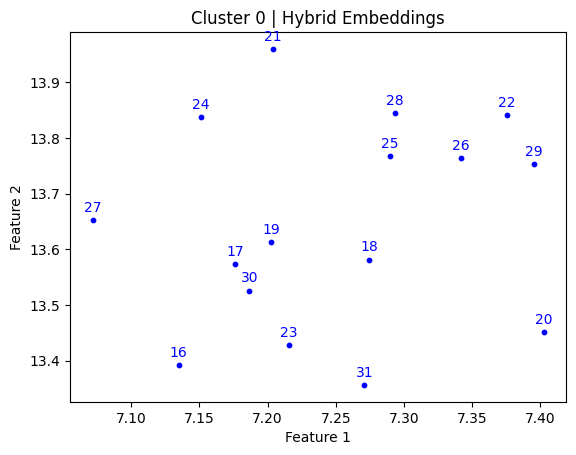

16 - https://factchecking.cl/user-review/de-aprobarse-la-nueva-constitucion-sistemas-de-justicia-seran-normados-por-legislacion-posterior/
17 - https://factchecking.cl/user-review/la-propuesta-de-nueva-constitucion-si-le-permite-a-los-privados-la-creacion-de-establecimientos-educacionales/
18 - https://factchecking.cl/user-review/la-constitucion-propuesta-garantiza-el-libre-e-igualitario-acceso-al-sistema-de-salud-pero-sera-la-legislacion-futura-la-que-definira-como/
19 - https://factchecking.cl/user-review/la-constitucion-vigente-no-menciona-los-conceptos-de-discapacidad-accesibilidad-inclusion-o-diversidad-pero-si-lo-hace-la-actual-legislacion/
20 - https://factchecking.cl/user-review/consultas-indigenas-no-serian-vinculantes-para-reformas-constitucionales-pero-la-ley-decidira-sobre-su-incidencia-en-nuevos-procesos-constituyentes/
21 - https://factchecking.cl/user-review/la-propuesta-de-nueva-constitucion-establece-el-agua-y-el-aire-como-bienes-inapropiables-incluyendo-las-playas-del

In [18]:
cluster_to_print = 0
embeddings_selected = []
facts_labels = []
for index, emb in enumerate(pages_embeddings_info):
    if emb.get_cluster() == cluster_to_print:
        embeddings_selected.append(emb)

# plt.scatter([fact.get_embedding()[0] for fact in embeddings_selected], [fact.get_embedding()[1] for fact in embeddings_selected], s=10)

colors = ['red', 'blue', 'green']

# reference_data = [fact[0] for fact in facts_selected]
for emb, etiqueta in zip([emb.get_embedding() for emb in embeddings_selected], [emb.get_label() for emb in embeddings_selected]):
    x = emb[0]
    y = emb[1]
    # reference = 0
    # times = 0
    # for index, cordx in enumerate(reference_data):
    #     if cordx == x:
    #         continue
    #     diff = abs(cordx - x)
    #     if diff < 0.1:
    #         reference += 7
    #         times += 1
    #         del reference_data[index]

    # if times >= 3:
    #     times = int(times/3)
    #     if times >= 3:
    #         times = 2
    plt.annotate(etiqueta, (x, y), textcoords="offset points", xytext=(0, 6), ha='center', color="blue")
    plt.scatter(x, y, s=10, color="blue")

# legend_labels = [mpatches.Patch(color=color, label=label) for label, color in colors.items()]
# plt.legend(handles=legend_labels, title="Sites", fontsize=8)

plt.title(f'Cluster {cluster_to_print} | Hybrid Embeddings')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
# plt.xlim(13.8, 14.8)
# plt.ylim(1.25, 2.75)
plt.show()

for emb in embeddings_selected:
    print(f"{emb.get_label()} - {emb.get_page()['link']}")

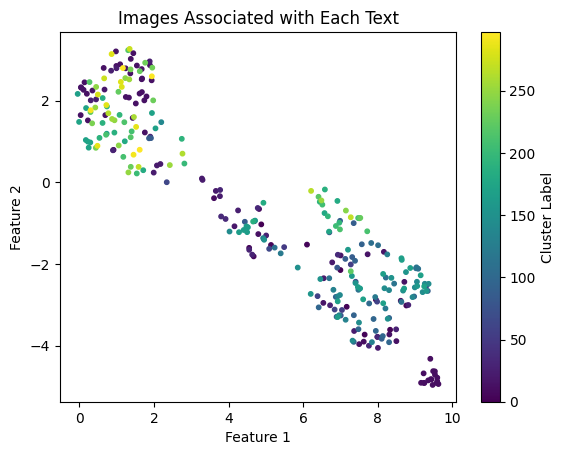

In [30]:
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_relationships, cmap='viridis', s=10)
plt.title('Images Associated with Each Text')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

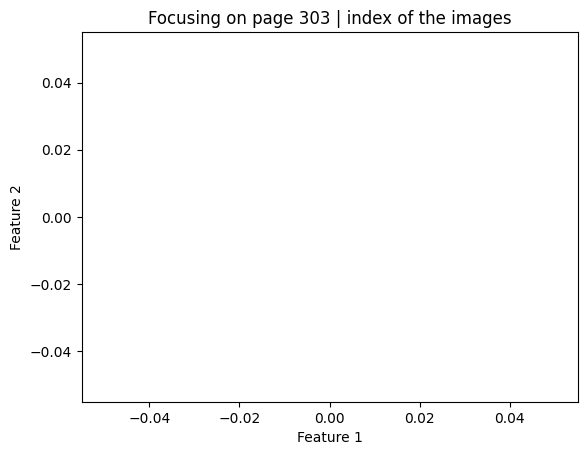

In [31]:
page_to_print = 303

facts_selected = []
facts_labels = []

for index, fact in enumerate(embeddings_2d):
    if cluster_relationships[index] == page_to_print:
        facts_selected.append(embeddings_2d[index].tolist())
        facts_labels.append(index)

labels = []
labels_index = []
labels_relation = []

for index, image in enumerate(image_relationships):
    if index in facts_labels:
        labels_relation.append(image["page"]["veracity"])
        if image["page"]["veracity"] not in labels:
            labels.append(image["page"]["veracity"])
        labels_index.append(labels.index(image["page"]["veracity"]))

plt.scatter([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], s=10)

for x, y, etiqueta in zip([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], facts_labels):
    plt.annotate(etiqueta, (x, y), textcoords="offset points", xytext=(0, 3), ha='center')

plt.title(f'Focusing on page {page_to_print} | index of the images')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

for index in facts_labels:
    print(f"[{index}]   Imagen: {image_relationships[index]['image']['image']}")
    print(f"[{index}]   Pagina: {image_relationships[index]['page']['link']}")
    print(f"[{index}]   indice de página: {cluster_relationships[index]}")
    print("")

## Show Cluster by image index


In [32]:
image_index = 416
hdbscan_cluster_to_print = cluster_labels[image_index]
print(hdbscan_cluster_to_print)
facts_selected = []
facts_labels = []
text_cluster = []

for index, fact in enumerate(embeddings_2d):
    if cluster_labels[index] == hdbscan_cluster_to_print:
        facts_selected.append(embeddings_2d[index].tolist())
        facts_labels.append(index)
        text_cluster.append(cluster_relationships[index])

plt.scatter([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], c=text_cluster, cmap='viridis', s=10)
for x, y, label in zip([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], facts_labels):
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 3), ha='center')
plt.title(f'Focusing on Cluster {hdbscan_cluster_to_print}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

for index in facts_labels:
    print(f"[{index}]   Imagen: {image_relationships[index]['image']['image']}")
    print(f"[{index}]   Pagina: {image_relationships[index]['page']['link']}")
    print(f"[{index}]   indice de página: {cluster_relationships[index]}")
    print("")


IndexError: index 416 is out of bounds for axis 0 with size 300

## Show cluster by fact index


In [ ]:
# Una misma noticia, como tiene varias imagenes, es posible entonces que la noticia como tal esté en más de un cluster.
fact_index = 0

if fact_index not in cluster_relationships:
    print("No se encontró la noticia en los clusters")
    exit()

hdbscan_clusters_to_print = []
for index, relation in enumerate(cluster_relationships):
    if relation == fact_index:
        hdbscan_clusters_to_print.append(cluster_labels[index])
hdbscan_clusters_to_print = list(set(hdbscan_clusters_to_print))

if len(hdbscan_clusters_to_print) == 0:
    print("No se encontraron clusters asociados a la noticia")
    exit()

print("clusters de HDBSCAN asociados a la noticia: ")
for cluster in hdbscan_clusters_to_print:
    print(f"[{cluster}]")


facts_selected = []
facts_labels = []
text_cluster = []
for index, fact in enumerate(embeddings_2d):
    if cluster_labels[index] == hdbscan_clusters_to_print[0]:
        facts_selected.append(embeddings_2d[index].tolist())
        facts_labels.append(index)
        text_cluster.append(cluster_relationships[index])


plt.scatter([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], c=text_cluster, cmap='viridis', s=10)
for x, y, label in zip([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], facts_labels):
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 3), ha='center')
plt.title(f'Focusing on Cluster {hdbscan_clusters_to_print[0]}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()


for index in facts_labels:
    print(f"[{index}]   Imagen: {image_relationships[index]['image']['image']}")
    print(f"[{index}]   Pagina: {image_relationships[index]['page']['link']}")
    print(f"[{index}]   indice de página: {cluster_relationships[index]}")
    print("")